In [1]:
%cd ..

/nfs/scistore16/edelgrp/fzimin/depth-poset


/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os

import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import gudhi as gh

from src.depth import DepthPoset


#from tqdm.notebook import tqdm
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import cm
from networkx import draw_networkx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import lines as mlines

from src.depth import DepthPoset


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/ipykern

AttributeError: _ARRAY_API not found

# Load and Format the Data

In [3]:
directory = "results/transpositions-during-linear-homotopy-between-barycentric-cubical-toruses"
paths = np.sort([f'{directory}/{f}' for f in os.listdir(directory)])

# the files are too big
#paths = paths[:420]

#df = pd.concat([pd.read_pickle(path) for path in tqdm(paths)])
df = []
errs = {}
for path in tqdm(paths):
    if os.path.getsize(path) < 160*1024**2:
        try:
            df.append(pd.read_pickle(path))
        except Exception as err:
            errs.update({path: err})
    else:
        errs.update({path: 'Giant file'})
errs = pd.Series(errs)
if len(errs) > 0:
    errs_count = errs.astype(str).value_counts()
    print(f'There is some amount of errors:\n{errs_count.to_string(name=False)}\n')
    #for path in errs.index:
    #    if os.path.exists(path):
    #        os.remove(path)
    
df = pd.concat(df)

if not 'complex_n' in df.columns: 
    df.insert(3, 'complex_n', df['complex_shape'].apply(lambda x: x[0] if (np.array(x)[1:] == np.array(x)[:-1]).all() else None))

print(f'df.shape = {df.shape}')
df.head()

100%|██████████| 644/644 [01:23<00:00,  7.72it/s] 


There is some amount of errors:
Giant file    150

df.shape = (113213, 30)


,complex_index0,complex_index1,complex_dim,complex_n,complex_shape,index 0,index 1,cell 0,cell 1,dim,...,birth_relation_cell_similarity,birth_relation_index_similarity,death_relation_cell_similarity,death_relation_index_similarity,poset_arc_cell_similarity,poset_arc_index_similarity,poset_node_cell_similarity,poset_node_index_similarity,relation_cell_similarity,relation_index_similarity
0,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.777563,1,4,"(4,)",0,1,"((0,),)","((1,),)",0,...,None,None,None,None,None,None,None,None,None,None
1,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.777563,1,4,"(4,)",0,1,"((2,),)","((0,),)",0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.2,1.0,0.0,1.0
2,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.777563,1,4,"(4,)",1,2,"((1,),)","((2,),)",0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.2,1.0,0.0,1.0
3,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.777563,1,4,"(4,)",5,6,"((0,), (1,))","((1,), (2,))",1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0
4,2025-06-18 16:08:54.761551,2025-06-18 16:08:54.777563,1,4,"(4,)",5,6,"((0,), (1,))","((2,), (3,))",1,...,0.0,1.0,0.0,0.0,0.0,1.0,0.5,1.0,0.0,1.0


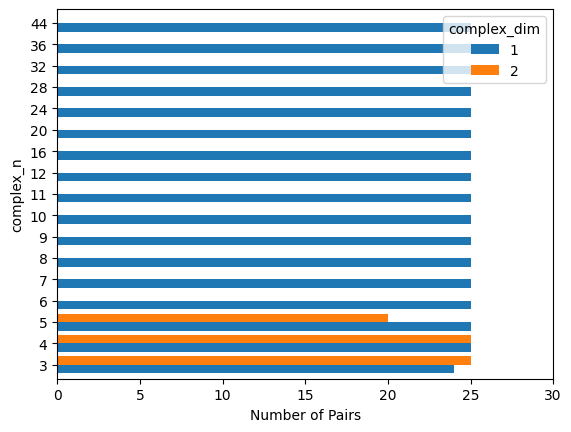

In [4]:
df.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n']
           )['index 0'].count().reset_index().groupby(['complex_dim', 'complex_n']
            )['complex_index0'].count().reset_index().pivot_table(columns='complex_dim', index='complex_n', values='complex_index0').fillna(0).astype(int).plot(kind='barh', width=0.8)

plt.xlabel('Number of Pairs')
xticks, _ = plt.xticks()
xticks = np.unique(np.array(xticks).astype(int))
plt.xticks(xticks)

plt.show()

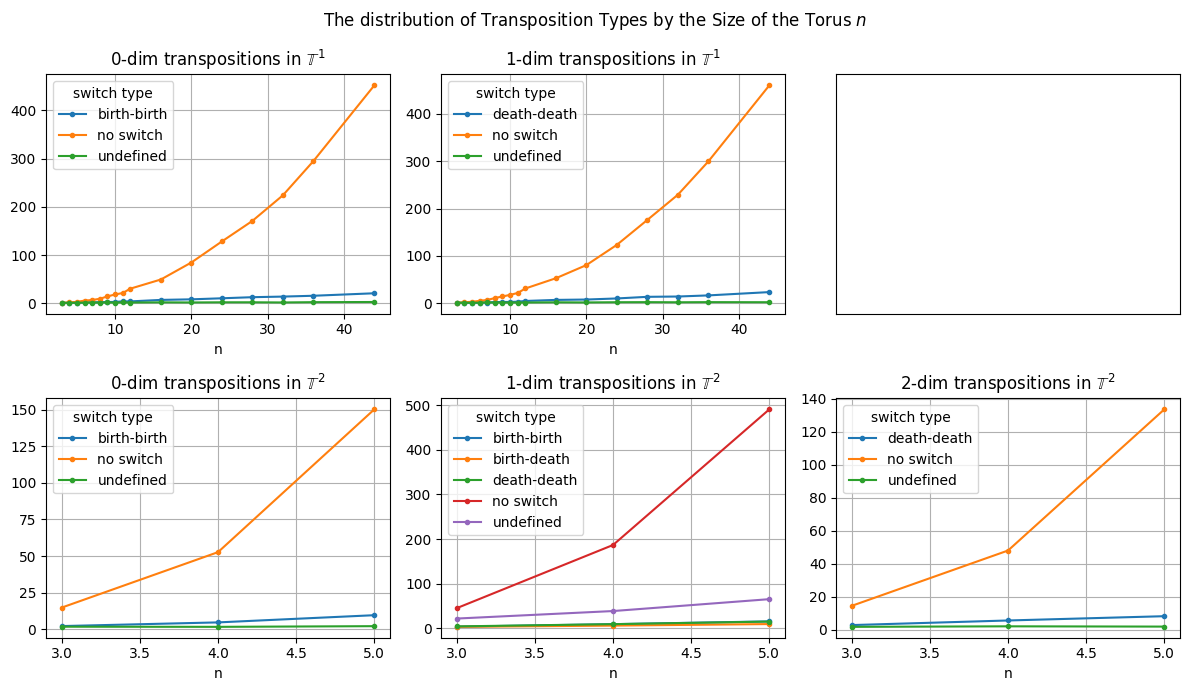

In [5]:
df_switch_types = df.copy()

df_switch_types.loc[(df_switch_types['switch'] == 'switch forward') | (df_switch_types['switch'] == 'switch backward'), 'switch'] = 'switch'
df_switch_types['switch type'] = df_switch_types.apply(lambda row: row['type'] if row['switch'] == 'switch' else row['switch'], axis=1)

df_switch_types = df_switch_types.groupby(['complex_index0', 'complex_index1', 'complex_dim', 'complex_n', 'dim', 'switch type'])['index 0'].count().reset_index().rename(columns={'index 0': 'count'})
df_switch_types = df_switch_types.groupby(['complex_dim', 'complex_n', 'dim', 'switch type'])['count'].mean().reset_index()
df_switch_types = df_switch_types.pivot_table(index='complex_n', columns=['complex_dim', 'dim', 'switch type'], values='count')

complex_dims = pd.unique(df['complex_dim'])
transposition_dims = pd.unique(df['dim'])

fig, axs = plt.subplots(len(complex_dims), len(transposition_dims), figsize=(4*len(transposition_dims), 3*len(complex_dims) + 1))
fig.suptitle('The distribution of Transposition Types by the Size of the Torus $n$')
for i, complex_dim in enumerate(complex_dims):
    for j, transposition_dim in enumerate(transposition_dims):
        try:
            df_switch_types[complex_dim][transposition_dim].plot(ax=axs[i, j], marker='.')
            axs[i, j].set_title(f'{transposition_dim}-dim transpositions in $\\mathbb{{T}}^{{\;{complex_dim}}}$')
            axs[i, j].grid(True)
            axs[i, j].set_xlabel('n')
        except KeyError:
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
plt.tight_layout()
